# Exploratory Data Analysis

In [1]:
import sys
sys.path.append('/Users/efraflores/Desktop/hub/asimov_generator/venv/lib/python3.9/site-packages')

## Parameters

In [2]:
import os

BASE_DIR = '/Users/efraflores/Desktop/EF/Diplo/Asimov' #'/content' if you're using GColab
print(os.listdir(BASE_DIR))
SPLIT_PATTERN = "[\.\?\!]" #How you want to split your text into sentences
EMBEDDING_DIM = 300 #from (50,100,200,300) possible embeddings with GloVe

['glove.6B.300d.txt', 'asimov_features.csv', '.DS_Store', 'glove.6B.100d.txt', 'corpus.txt', 'glove.6B.50d.txt', 'rnn_asimov_weights.h5', 'project', 'glove.6B.200d.txt', 'doc', 'rnn_asimov_architecture.json', 'glove.6B.zip', 'rnn_asimov_tokenizer.pickle', 'The_Last_Question.pdf']


## Functions

In [3]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

In [4]:
#Uncomment the following lines if it's the first time you run this packages
'''
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
'''
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def clean_text(text,
               language='english',pattern="[^a-zA-Z' ]",
               lower=False,lemma=False,rem_stopw=False,unique=False,
               add_stopw=[]):
    #It clean and can remove stopwords or even lemmatize words if specified in params
    cleaned_text = unicodedata.normalize('NFD',str(text).replace('\n','')).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern,' ',cleaned_text.decode('utf-8'),flags=re.UNICODE)
    cleaned_text = [(lem.lemmatize(word,pos='v') if lemma else word) for word in 
                    (cleaned_text.lower().split() if lower else cleaned_text.split())]
    if rem_stopw: cleaned_text = [word for word in cleaned_text if word not in 
                                  stopwords.words(language)+add_stopw]
    return ' '.join((set(cleaned_text) if unique else cleaned_text))

#Ex
ex = "I am going to run!!! I ran while I was running??? ..."
print('\nOriginal:\t\t',ex)
print('Basic cleaning:\t\t',clean_text(ex))
print('Changing the pattern:\t',clean_text(ex,pattern="[^a-zA-Z!\.]"))
print('Without stopwords:\t',clean_text(ex,rem_stopw=True))
print('Lower and lemma:\t',clean_text(ex,lower=True,lemma=True))
print('Super cleaning:\t\t',clean_text(ex,add_stopw=['go'],lower=True,rem_stopw=True,lemma=True,unique=True))
print("\nIt actually corrects the weird accents, example\n\tFROM:\t ThÈ ÉfrâïsMã's?...\n\tTO:\t",clean_text("ThÈ ÉfrâïsMa's?...",lower=True))


Original:		 I am going to run!!! I ran while I was running??? ...
Basic cleaning:		 I am going to run I ran while I was running
Changing the pattern:	 I am going to run!!! I ran while I was running ...
Without stopwords:	 I going run I ran I running
Lower and lemma:	 i be go to run i run while i be run
Super cleaning:		 run

It actually corrects the weird accents, example
	FROM:	 ThÈ ÉfrâïsMã's?...
	TO:	 the efraisma's


In [5]:
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(text):
    sid = SentimentIntensityAnalyzer()
    try:
        list(map(sid.polarity_scores,sent_tokenize(text)))[0]
    except:
        sentences = sent_tokenize('a')
    else:
        sentences = sent_tokenize(text)
    res = map(sid.polarity_scores, sentences)
    return list(res)[0]

print(sentiment('I love it'))
print(sentiment('I hate it'))
print(sentiment('It is ok'))

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.296}


In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
#The tutorial for Transfer Embedding is right here!
#  https://keras.io/examples/nlp/pretrained_word_embeddings/

#If you're running this in GColab, uncomment the following lines to unzip the GloVe embeddings
#  (more info about GloVe at https://nlp.stanford.edu/projects/glove/),
#  but if you're working locally, move the files from the zip to your base_dir

'''!wget http://nlp.stanford.edu/data/glove.6B.zip 
!unzip -q glove.6B.zip'''

def transfer_embedding(base_dir,fitted_tokenizer,embedding_dim_out):
    #Get the pre-trained vectors as a dict
    emb_dict = {}
    with open(os.path.join(base_dir,f'glove.6B.{embedding_dim_out}d.txt')) as f:
        for line in f:
            #Each line is a word with its coef sep by \s
            word, coefs = line.split(maxsplit=1)
            #Like .split() transforming strings into an array
            coefs = np.fromstring(coefs,'f',sep=' ')
            #Update the dict with a new word and its coef
            emb_dict[word] = coefs
    #Keep track of the not-found words
    misses = []
    #Build a matrix full of zeros
    total_words = fitted_tokenizer.word_index
    words_matrix = np.zeros((len(total_words),embedding_dim_out))
    #Loop over the words-indexes...
    for word, i in total_words.items():
        #... to get its pre-trained value
        try: word_vector = emb_dict[word]
        #Some words won't be found, keep the zeros-vector
        except: misses.append(word)
        #Finally, transfer the pre-trained vector
        else: words_matrix[i-1] = word_vector
    print(f'Transfered {"{:.1%}".format(1-len(misses)/len(total_words))}% of {len(total_words)} words, just {len(misses)} were not found.')
    #Returns the dict_index of every word and other dict with its embedding
    return total_words,dict(zip(total_words.keys(),words_matrix)),misses

In [7]:
'''!pip install pygal'''
import pygal
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

def koptimo(df):
    sse,db,slc = {}, {}, {}
    for k in range(2, 16):
        kmeans = KMeans(n_clusters = k, max_iter= 100, random_state = 22).fit(df)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ 
        db[k] = davies_bouldin_score(df, clusters)
        slc[k] = silhouette_score(df, clusters)

    dicts = [sse,db,slc]

    for dicc in dicts:
        min_value = min(list(dicc.values()))
        max_value = max(list(dicc.values()))
        for k in dicc.keys():
            dicc[k] = (dicc[k] - min_value + 1)/(max_value - min_value + 1)

    line_chart = pygal.Line()
    line_chart.title = 'K-óptimo'
    line_chart.x_labels = map(str, sse.keys())
    for name, dicc in zip(['Inertia','DB','Silhouette'],dicts):
        line_chart.add(name, list(map(lambda x: round(x,2), dicc.values())))
    display(line_chart)

In [8]:
'''!pip install seaborn'''
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def clustering(df,
               cols,
               n_clusters=5,
               kmeans=False):
    df = df.copy()
    mm_df = MinMaxScaler()
    Xs = pd.DataFrame(mm_df.fit_transform(df[cols]), 
                      index = df.index,
                      columns = cols)
    
    cluster = (KMeans(n_clusters, random_state=22) if kmeans 
               else GaussianMixture(n_clusters, random_state=22))
    Xs['cluster'] = cluster.fit_predict(Xs)
    
    dict_cluster = dict(enumerate(string.ascii_uppercase[:n_clusters]))
    df['cluster'] = Xs['cluster'].map(dict_cluster) 
    print(f'Distribución de registros en los {n_clusters} clústeres')
    display(df['cluster'].value_counts(1).reset_index().sort_values(by='index'))

    pca = PCA(2)
    pipe_pca = Pipeline(steps=[('MinMax', mm_df),('PCA', pca)])
    Xg = pd.DataFrame(pipe_pca.fit_transform(df.iloc[:,:-1]), 
                      index = df.index,
                      columns = ['p1','p2'])
    Xg['cluster'] = df['cluster'].copy()
    print(f'Varianza explicada con 2dim: {"{:.1%}".format(pca.explained_variance_ratio_.sum())}')
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=Xg.sort_values(by='cluster'),
                    x='p1',
                    y='p2',
                    alpha=0.5,
                    hue='cluster', 
                    palette = 'Paired')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show();
    
    return df

In [9]:
def perfilamiento(df,cols=None,cluster='cluster'):
    n_clusters = len(set(df[cluster]))
    
    if cols==None:
        cols=df.columns
        aux = df[cols].groupby(cluster).mean()
        #aux = aux.transpose()
        for col in aux.columns:
            aux[col] /= aux[col].sum()

        fig = plt.figure()
        fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(aux.columns)/3))))
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.9)
        sns.heatmap(aux.transpose(),cmap='Blues')
        plt.show();
        
    else:
        for col in cols:
            aux = df.copy()
            aux['n'] = 1
            aux = aux.pivot_table(index=cluster,
                                  columns=col,
                                  values='n',
                                  aggfunc='count',
                                  fill_value=0)
            for columna in aux.columns:
                aux[columna] /= aux[columna].sum()

            fig = plt.figure()
            fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(set(df[col]))/4))))
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(0.9)
            sns.heatmap(aux.transpose(), cmap = 'Blues')
            plt.show();

## Transform

### Sentences

In [10]:
with open(os.path.join(BASE_DIR,'corpus.txt')) as txt:
    #Make sentences with the split-pattern provided and return just the non-empty sentences
    corpus = [x for x in re.split(SPLIT_PATTERN,txt.read()) if len(x)>0]
    
print(corpus[:2])

[',\n,"The Last Question By Isaac Asimov  This is by far my favorite story of all those I have written', '  \nAfter all, I undertook to tell several trillion \nyears of human history in the space of a short \nstory and I leave it to you as to how well I succeeded']


### Features

In [11]:
import pandas as pd
df = pd.DataFrame(corpus,columns=['sentence'])
df['clean'] = df['sentence'].apply(lambda x: clean_text(x,lower=True))
df['min_text'] = df['sentence'].apply(lambda x: clean_text(x,lower=True,lemma=True,
                                                           rem_stopw=True,unique=True)+' a')
df['length'] = df['clean'].apply(len)
df['relevance'] = df['min_text'].apply(len) / (df['length']+1e-10)
df = df.join(pd.DataFrame(list(map(sentiment,df['clean']))))
df.sample()

,sentence,clean,min_text,length,relevance,neg,neu,pos,compound
268,"""""And you",and you,a,7,0.285714,0.0,1.0,0.0,0.0


### Embedding

In [12]:
#Tokenize the words to feed the ANN
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['min_text'])
total_words,words_matrix,missed_words = transfer_embedding(BASE_DIR,tokenizer,EMBEDDING_DIM)
print(missed_words)

Transfered 94.8%% of 902 words, just 47 were not found.
['jerrodd', "we'll", 'microvac', 'lupov', 'jerrodine', "can't", 'jerrodette', "prime's", "i'm", "that's", 'visiplate', "man's", "multivac's", "earth's", "lupov's", "we've", 'hyperspatial', 'cellufilm', "we're", 'lupow', "it'll", "everything's", "'forever", "adell's", 'jerrodettes', 'insideoutness', "''automatic", "jerrodine's", "pete's", "father's", 'planetarv', "what's", "they're", "i'll", "he'll", 'insuficient', 'lameth', 'nicron', 'gaiaxy', "there's", "i've", 'submesons', 'tlme', "'i", 'tlmes', 'predecesors', "'when"]


In [13]:
from sklearn.decomposition import PCA

for perc in range(10,100,10):
    aux = df['min_text'].apply(lambda row:np.percentile(np.array([words_matrix[x]
                                                                  for x in row.split()]),
                                                        perc,axis=0))
    aux = pd.DataFrame(aux)
    aux = pd.DataFrame(aux['min_text'].to_list())
    aux = pd.DataFrame(PCA(.9).fit_transform(aux))
    df=df.join(aux.rename(columns={x:str(perc)+'_'+str(x).zfill(2) for x in aux.columns}))

In [14]:
df = df.set_index('clean').drop(columns=['sentence','min_text'])
df.sample()

,length,relevance,neg,neu,pos,compound,10_00,10_01,10_02,10_03,...,90_77,90_78,90_79,90_80,90_81,90_82,90_83,90_84,90_85,90_86
clean,,,,,,,,,,,,,,,,,,,,,
his mind released its hold on the original galaxy of man let it spring back and lose itself among the blurred pin points,120,0.675,0.104,0.808,0.088,-0.1027,-1.331092,0.120705,0.308194,-0.366798,...,0.269295,0.032437,-0.090475,0.04298,-0.061629,0.029883,-0.040354,-0.168605,-0.07316,0.035488


## Clustering

### N clusters

ModuleNotFoundError: No module named 'cairosvg'

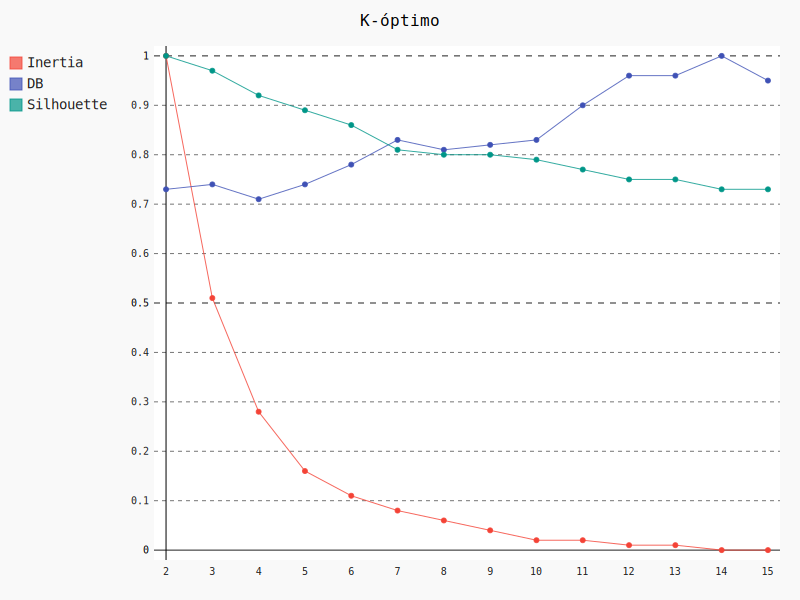

In [15]:
koptimo(df)

### Model

Distribución de registros en los 5 clústeres


,index,cluster
4,A,0.005141
2,B,0.239075
3,C,0.141388
1,D,0.272494
0,E,0.341902


Varianza explicada con 2dim: 3.5%


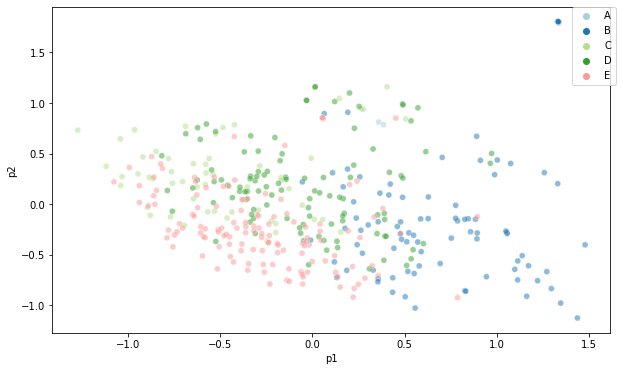

In [16]:
df = clustering(df,df.columns,n_clusters=5,kmeans=True)

### Difference between clusters

<Figure size 432x288 with 0 Axes>

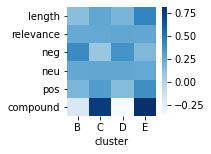

In [24]:
aux = df.iloc[:,:6].join(df['cluster'])
perfilamiento(aux[aux['cluster']!='A'])

A


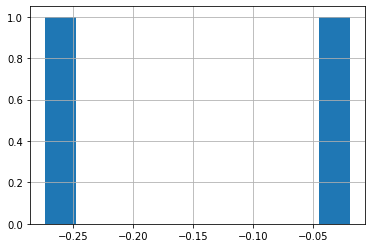

B


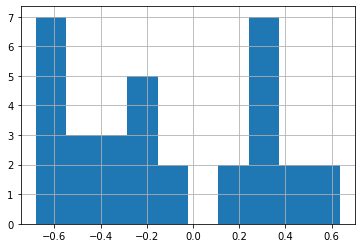

D


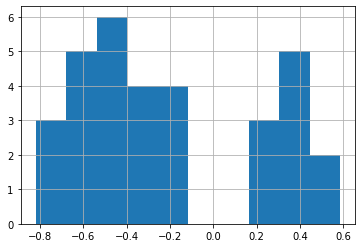

C


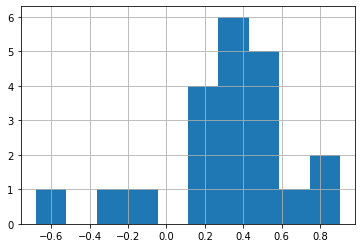

E


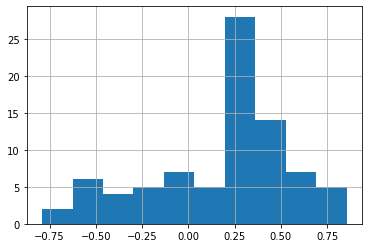

In [18]:
for cluster in set(df['cluster']):
    print(cluster)
    plt.show(df[(df['cluster']==cluster)&(df['compound']!=0)]['compound'].hist())

In [27]:
df[df['cluster']=='B'].index

Index(['they had no intention originally of disturbing it',
       'lupov cocked his head sideways', 'oh hell just about forever',
       'that's not forever', 'i don't have to ask multivac',
       'that's all i'm saying',
       'lupow pointed a slightly shaky finger at the other', 'they rested',
       'you're weak on logic that's the trouble with you', 'don't shout',
       'darn right they will muttered lupov', 'the hell you do', 'why not',
       'someday', 'ask multivac', 'you ask multivac',
       'multivac fell dead and silent', 'no bet whispered lupov',
       'they left hurriedly',
       'by next morning the two plagued with throbbing head and cottony mouth had forgotten the incident',
       'jerrodd jerrodine and jerrodette i and ii watched the starry picture in the visiplate change as the passage through hyperspace was completed in its non time lapse',
       'that's x said jerrodd confidently', 'are you sure jerrodd',
       'jerrodine's eyes were moist as she watched t

## End

In [19]:
time_exp(time.time()-start)
tone()

0 minutos con 41.21 segundos
